In [1]:
import matplotlib.pyplot as plt
import pywt
import mne
import numpy as np
import pandas as pd

In [2]:
WAVELETNAME = 'morl'
edf_dir = r"Jean-Pol_repaired_headers"
from MyEDFImports import import_ecg, get_edf_filenames

edfs_names = get_edf_filenames()

In [3]:
#Here I want to get stages and the date that the stages took place in
def date_from_comment(file):
    with open(file) as f:
        for line in f:
            if line.startswith("% night ="):
                return line[-11:-1]


Getting stages from one file with dates

In [4]:
name = edf_dir +'//'+ edfs_names[0] + '_stages.txt'
record_day = pd.to_datetime(date_from_comment(name))
begining_of_time = pd.to_datetime('1900-01-01')
day_shift = record_day - begining_of_time
stages = pd.read_csv(name, comment='%', delimiter='	', index_col=0).drop('Unnamed: 3', axis=1)
stages['Time'] = pd.to_datetime(stages['Time'], format='%H:%M:%S') + day_shift
stages.index = stages.index -1
stages

/tmp/ipykernel_5280/2837210468.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  record_day = pd.to_datetime(date_from_comment(name))


,Time,stage
Index,,
0,2005-11-29 21:35:12,0
1,2005-11-29 21:35:32,0
2,2005-11-29 21:35:52,0
3,2005-11-29 21:36:12,0
4,2005-11-29 21:36:32,0
...,...,...
2002,2005-11-29 08:42:32,0
2003,2005-11-29 08:42:52,0
2004,2005-11-29 08:43:12,0


Getting counted stages from all files without dates

In [5]:
import os
all_files = os.listdir(edf_dir)
big_edf_files = list(filter(lambda x: 'EDF' in x, all_files))
newnames = []
for name in big_edf_files:
    ind = name.index('EDF')

    newname = name[:ind] + 'edf' + name[ind+3:]
    newnames.append(newname)
for (x,y) in (zip(big_edf_files, newnames)):
    print('changing name of {x}')
    os.rename(edf_dir + '//' + x,edf_dir + '//' + y)


In [6]:
os.rename(*('rere.txt','requirements.txt'))

In [7]:
# cleaning from "_wake" and such
edfs_names = [name for name in edfs_names if '_' not in name]
all_stages = []
for name in edfs_names:
    fname = edf_dir +'//'+ name + '_stages.txt'
    print(fname)
    stages = pd.read_csv(fname, comment='%', delimiter='	', index_col=0).drop('Unnamed: 3', axis=1)
    raw_stages = np.copy(stages['stage'])
    all_stages.extend(raw_stages)
from collections import Counter
counted = Counter(all_stages)



Jean-Pol_repaired_headers//CP229110.edf_stages.txt
Jean-Pol_repaired_headers//WD224010.edf_stages.txt
Jean-Pol_repaired_headers//TK221110.edf_stages.txt
Jean-Pol_repaired_headers//VP214110.edf_stages.txt
Jean-Pol_repaired_headers//CN223100.edf_stages.txt
Jean-Pol_repaired_headers//LM230010.edf_stages.txt
Jean-Pol_repaired_headers//VC209100.edf_stages.txt
Jean-Pol_repaired_headers//LA216100.edf_stages.txt
Jean-Pol_repaired_headers//DG220020.edf_stages.txt
Jean-Pol_repaired_headers//DO223050.edf_stages.txt
Jean-Pol_repaired_headers//CX230050.edf_stages.txt


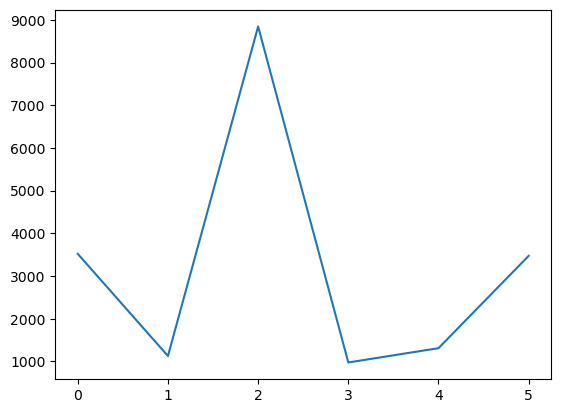

In [8]:
import matplotlib.pyplot as plt
sorted_keys = sorted(dict(counted).keys())
counted = {k:counted[k] for k in sorted_keys}
plt.plot(counted.keys(), counted.values())

In [9]:
counted

{0: 3519, 1: 1127, 2: 8844, 3: 975, 4: 1310, 5: 3473}

In [10]:
dict(counted)[0]

3519

In [11]:
edfs = [import_ecg(edf) for edf in edfs_names[:4]]

Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CP229110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/WD224010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/TK221110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/VP214110.edf...
EDF file detected
Setting chann

/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)
/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:19: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


Getting all data split into 20sec intervals

In [12]:
# name = edf_dir +'//'+ edfs_names[0] + '_stages.txt'
for edf in edfs:
    sampl_freq = edf.info["sfreq"]
    nr_windows = int(len(edf[0][1]) // sampl_freq // 20)
    windows = []
    for i in range(nr_windows):
        windows.append(edf.time_as_index([20*i,20*(i+1)]))

In [13]:
for edf in edfs[:1]:
    print(edf.info['meas_date'])

2005-11-29 21:35:12+00:00


In [14]:
import pywt
raw = edfs[0]
sampl_freq = raw.info["sfreq"]
windows = int(len(raw[0][1]) // sampl_freq // 20)
atributes, frequencies = [], []
for i in range(windows):

    start_stop_ind = raw.time_as_index([20*i,20*(i+1)])
    start = start_stop_ind[0]
    stop = start_stop_ind[1]
    y = raw[0,start:stop][0]
    y = np.reshape(y,-1)
    if i % 300 == 0:
       print("CWT nr :", i)
    cwt_atr, cwt_freqs =  pywt.cwt(y, np.arange(1,129), WAVELETNAME)
    atributes.append(cwt_atr)
    frequencies.append(cwt_freqs)


CWT nr : 0
CWT nr : 300
CWT nr : 600
CWT nr : 900
CWT nr : 1200
CWT nr : 1500
CWT nr : 1800


2. CWT of 1 edf file calclulated in about 8 minutes and weighing over 15 GB.

np.save('tempname2', [1,2,3])

filename = "tempname"
with open(filename, 'wb') as f:

    np.save(f, atributes)

In [15]:
sizeof(frequencies)

NameError: name 'sizeof' is not defined

In [ ]:
sizeof(atributes) // sizeof(frequencies)

atr = np.array(atributes)
frequencies = np.array(frequencies)

atr = [o.shape for o in frequencies]
np.all(atr == tuple(128))

type(atr[0])

# here i want to have divided in 20s
twenty_sec = edfs[0].crop(0,20)
twenty_sec_2 = edfs[0].crop(20,40)
import matplotlib.pyplot as plt
plt.plot(twenty_sec[0][0].T)